# RAW CODE
Aidan H & Zahara M - Monthly Average Ridership by Route & Weekday - https://data.wprdc.org/dataset/prt-monthly-average-ridership-by-route/resource/12bb84ed-397e-435c-8d1b-8ce543108698 - 'Monthly OTP by Route' - https://data.wprdc.org/dataset/port-authority-monthly-average-on-time-performance-by-route/resource/00eb9600-69b5-4f11-b20a-8c8ddd8cfe7a

Determinds the most used routes + the OTP and ranks the results.


Top 20 Most Used Routes (2023-2024):

 Rank                                    Route Label route  Average Riders (2023-2024)  OTP (Avg) 2023  OTP (Avg) 2024  OTP (Avg) 2023-2024
    1                              51 — 51 - CARRICK    51                        3987            65.9            65.5                 65.7
    2       RED — RED - Castle Shannon via Beechview   RED                        3736            84.9            79.5                 82.9
    3               61C — 61C - MCKEESPORT-HOMESTEAD   61C                        3598            54.7            48.1                 51.9
    4                P1 — P1 - EAST BUSWAY-ALL STOPS    P1                        3363            83.8            79.5                 82.0
    5                     61A — 61A - NORTH BRADDOCK   61A                        2855            59.1            56.8                 58.1
    6                      71B — 71B - HIGHLAND PARK   71B                        2569            63.9            53.6   

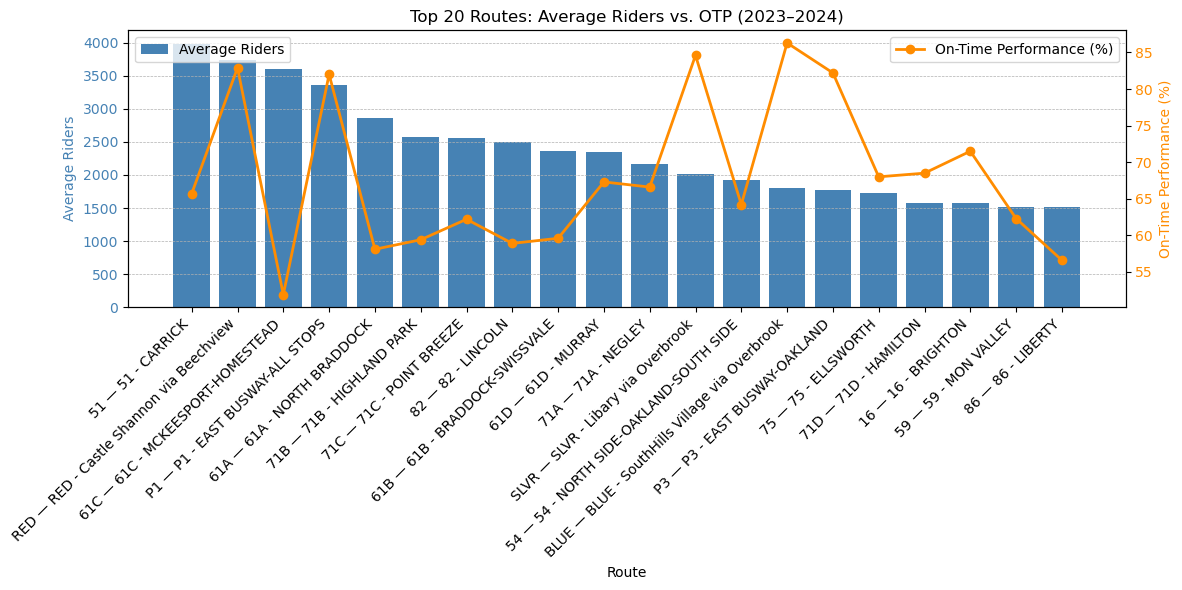

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# === Config ===
FILE_PATH      = "AverageRiders.csv"   # ridership by route, includes year_month
OTP_FILE_PATH  = "OTP.csv"             # on-time performance by route, includes year_month

ROUTE_NAME_COL = "route_full_name"
ROUTE_ID_COL   = "route"
RIDERS_COL     = "avg_riders"
YEAR_MONTH_COL = "year_month"
OTP_COL        = "on_time_percent"

TOP_N          = 20
YEAR_START     = 2023   # inclusive
YEAR_END       = 2024   # inclusive

def plot_top_routes(out_df, year_start, year_end, save_path=None):
    """
    Plots:
      - Blue bars: Average Riders (year_start–year_end)
      - Orange line: OTP (Avg) year_start–year_end in %
    """
    plot_df = out_df[[
        "Rank",
        "Route Label",
        f"Average Riders ({year_start}-{year_end})",
        f"OTP (Avg) {year_start}-{year_end}"
    ]].sort_values("Rank").reset_index(drop=True)

    x = range(len(plot_df))
    riders = plot_df[f"Average Riders ({year_start}-{year_end})"]
    otp_pct = plot_df[f"OTP (Avg) {year_start}-{year_end}"]

    fig, ax = plt.subplots(figsize=(12, 6))

    # Bars for riders (blue)
    ax.bar(x, riders, color="steelblue", label="Average Riders")
    ax.set_ylabel("Average Riders", color="steelblue")
    ax.set_xlabel("Route")
    ax.tick_params(axis="y", labelcolor="steelblue")

    # Line for OTP (orange)
    ax2 = ax.twinx()
    ax2.plot(x, otp_pct, color="darkorange", marker="o", linewidth=2, label="On-Time Performance (%)")
    ax2.set_ylabel("On-Time Performance (%)", color="darkorange")
    ax2.tick_params(axis="y", labelcolor="darkorange")

    # X-axis route labels
    route_labels = plot_df["Route Label"]
    ax.set_xticks(list(x))
    ax.set_xticklabels(route_labels, rotation=45, ha="right")

    # Title and grid
    ax.set_title(f"Top {len(plot_df)} Routes: Average Riders vs. OTP ({year_start}–{year_end})")
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

    # Legends
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

    fig.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    else:
        plt.show()

def main():
    # Load data
    df  = pd.read_csv(FILE_PATH)
    otp = pd.read_csv(OTP_FILE_PATH)

    # ---- Validate required columns ----
    ridership_required = [ROUTE_NAME_COL, ROUTE_ID_COL, RIDERS_COL, YEAR_MONTH_COL]
    otp_required       = [ROUTE_NAME_COL, ROUTE_ID_COL, OTP_COL, YEAR_MONTH_COL]

    miss_r = [c for c in ridership_required if c not in df.columns]
    miss_o = [c for c in otp_required if c not in otp.columns]
    if miss_r:
        raise ValueError(f"Ridership file missing columns: {miss_r}. Found: {list(df.columns)}")
    if miss_o:
        raise ValueError(f"OTP file missing columns: {miss_o}. Found: {list(otp.columns)}")

    # ---- Clean text columns ----
    for col in (ROUTE_NAME_COL, ROUTE_ID_COL):
        df[col]  = df[col].astype(str).str.strip()
        otp[col] = otp[col].astype(str).str.strip()

    # Display label
    def make_label(d: pd.DataFrame) -> pd.Series:
        return d[ROUTE_ID_COL].astype(str).str.strip() + " — " + d[ROUTE_NAME_COL].astype(str).str.strip()

    df["Route Label"]  = make_label(df)
    otp["Route Label"] = make_label(otp)

    # Riders
    df[RIDERS_COL] = (
        df[RIDERS_COL]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    df[RIDERS_COL] = pd.to_numeric(df[RIDERS_COL], errors="coerce")

    # year_month
    df[YEAR_MONTH_COL]  = pd.to_numeric(df[YEAR_MONTH_COL], errors="coerce")
    otp[YEAR_MONTH_COL] = pd.to_numeric(otp[YEAR_MONTH_COL], errors="coerce")

    # OTP
    otp[OTP_COL] = pd.to_numeric(otp[OTP_COL], errors="coerce")

    # Drop invalids
    df  = df.dropna(subset=[RIDERS_COL, YEAR_MONTH_COL])
    otp = otp.dropna(subset=[OTP_COL, YEAR_MONTH_COL])

    # ----------------------------
    # A) Rank routes by ridership
    # ----------------------------
    start_ym = YEAR_START * 100 + 1
    end_ym   = YEAR_END   * 100 + 12

    df_range = df[(df[YEAR_MONTH_COL] >= start_ym) & (df[YEAR_MONTH_COL] <= end_ym)].copy()
    if df_range.empty:
        raise ValueError(f"No ridership rows in {YEAR_START}-{YEAR_END}.")

    route_stats = (
        df_range
        .groupby(["Route Label", ROUTE_ID_COL, ROUTE_NAME_COL], as_index=False)[RIDERS_COL]
        .mean()
        .rename(columns={RIDERS_COL: f"Average Riders ({YEAR_START}-{YEAR_END})"})
    )
    route_stats[f"Average Riders ({YEAR_START}-{YEAR_END})"] = (
        route_stats[f"Average Riders ({YEAR_START}-{YEAR_END})"].round(0).astype(int)
    )

    # Top Routes
    top_routes = (
        route_stats.sort_values(f"Average Riders ({YEAR_START}-{YEAR_END})", ascending=False)
        .head(TOP_N)
        .reset_index(drop=True)
    )
    top_routes.insert(0, "Rank", range(1, len(top_routes) + 1))

    # ----------------------------
    # B) Compute OTP for 2023, 2024, and combined
    # ----------------------------
    otp_range = otp[(otp[YEAR_MONTH_COL] >= start_ym) & (otp[YEAR_MONTH_COL] <= end_ym)].copy()

    otp_2023 = otp_range[
        (otp_range[YEAR_MONTH_COL] >= 202301) & (otp_range[YEAR_MONTH_COL] <= 202312)
    ].groupby([ROUTE_ID_COL, ROUTE_NAME_COL], as_index=False)[OTP_COL].mean()
    otp_2023 = otp_2023.rename(columns={OTP_COL: "OTP (Avg) 2023"})

    otp_2024 = otp_range[
        (otp_range[YEAR_MONTH_COL] >= 202401) & (otp_range[YEAR_MONTH_COL] <= 202412)
    ].groupby([ROUTE_ID_COL, ROUTE_NAME_COL], as_index=False)[OTP_COL].mean()
    otp_2024 = otp_2024.rename(columns={OTP_COL: "OTP (Avg) 2024"})

    otp_combined = (
        otp_range.groupby([ROUTE_ID_COL, ROUTE_NAME_COL], as_index=False)[OTP_COL]
        .mean()
        .rename(columns={OTP_COL: f"OTP (Avg) {YEAR_START}-{YEAR_END}"})
    )

    # Merge OTP data
    out = top_routes.merge(otp_2023, on=[ROUTE_ID_COL, ROUTE_NAME_COL], how="left")
    out = out.merge(otp_2024, on=[ROUTE_ID_COL, ROUTE_NAME_COL], how="left")
    out = out.merge(otp_combined, on=[ROUTE_ID_COL, ROUTE_NAME_COL], how="left")

    # Format OTPs as %
    for c in ["OTP (Avg) 2023", "OTP (Avg) 2024", f"OTP (Avg) {YEAR_START}-{YEAR_END}"]:
        if c in out.columns:
            out[c] = (out[c] * 100).round(1)

    out = out[
        [
            "Rank",
            "Route Label",
            ROUTE_ID_COL,
            f"Average Riders ({YEAR_START}-{YEAR_END})",
            "OTP (Avg) 2023",
            "OTP (Avg) 2024",
            f"OTP (Avg) {YEAR_START}-{YEAR_END}",
        ]
    ]

    print(f"\nTop {TOP_N} Most Used Routes ({YEAR_START}-{YEAR_END}):\n")
    print(out.to_string(index=False))

    return out

# === Run main and plot in Jupyter ===
out_df = main()
plot_top_routes(out_df, YEAR_START, YEAR_END)